# sivtempfit tutorial 

## Getting started
First, import the package. If you need to download and install the package, please see the documentation on the [github page](https://github.com/p201-sp2016/sivtempfit).

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sivtempfit as stf
import sivtempfit.io as io
import sivtempfit.inferMC as mc
import sivtempfit.model as model
import emcee
import numpy as np
import pandas as pd
import seaborn as sns

## Import some data

In general, you will have some experimental data. For the purposes of this tutorial, let's import some example data. The package includes support for data in a simple `[x, y]` format where `x` is a numpy array of the x values and `y` is a numpy array of the y values.

The package also includes support for a `Spectrum` object, which is basically just a dataframe with a `metadata` variable bolted onto it, plus some json i/o utilities.

We'll use such a `Spectrum` object in this tutorial. Let's import it using the `io` module.

In [2]:
path_to_json = io.get_example_data_file_path("test_experimental_spectrum.json")
test_spectrum = io.load_Spectrum(path_to_json)

Now, `simulated_spectrum` is a `Spectrum` object that has both data and metadata:

In [3]:
test_spectrum.metadata

{'Laser Frequency': '401.496 THz',
 'Name': 'Example spectrum of an SiV plus a laser calibration line taken at 300K.'}

In [13]:
test_spectrum.data[:10]

,counts,wavelength
0,1157,730.7841
1,1161,730.7931
10,1170,730.8741
100,1168,731.6841
1000,1543,739.7841
1001,1540,739.7931
1002,1562,739.8021
1003,1550,739.8111
1004,1539,739.8201
1005,1589,739.8291


## Do some inference on this example data

Let's visualize the example data:

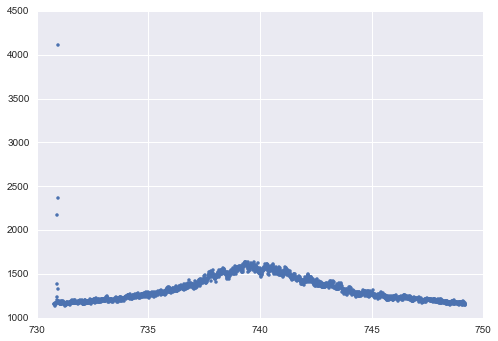

In [5]:
plt.plot(test_spectrum.data['wavelength'], test_spectrum.data['counts'], ".")

We have a model for this function that includes two lorentzian peaks plus gaussian background noise. The model is described in the likelihood function: 

In [6]:
print(model.two_peak_log_likelihood.__doc__)


    Returns the log-likelihood calculated for the two-peak + CCD noise model.
    See also: two_peak_model

    Parameters:
    -----------
    x : wavelength or x-axis value
    y : corresponding observed data value
    amp1 : amplitude of the broad SiV peak in the spectrum
    amp2 : amplitude of the narrow calibration peak in the spectrum
    T : The temperature of the sample
    m : The linear scaling of the SiV peak position with temperature
    C0 : The offset in the above linear scaling
    center2 : The position of the calibration line
    width1 : The width (FWHM) of the SiV line
    width2 : The width (FWHM) of the calibration line
    light_background : The contribution to the background from stray light,
                       contributing shot noise
    ccd_backgrond : The contribution to the background from CCD readout,
                    contributing gaussian noise
    ccd_stdev : The standard deviation on the gaussian CCD noise

    Optional Arguments:
    -----------

This likelihood function is the one used by the `emcee` sampler. To extract these parameters, we can use the included functionality of the `emcee` sampler to sample the likelihood. It begins by generating an `emcee` `sample_ball` object. This is normally done automatically in the course of evaluating `mc_likelihood_sampler` but can also be done manually for more fine-grained control. Here is an example of the guesses.

In [7]:
mc.generate_sample_ball(test_spectrum, 70, debug = True)

((2056.5,
  2056.5,
  669,
  70,
  2,
  0.02,
  64.025000000000006,
  1024.4000000000001,
  10),
 (1645.2, 1645.2, 3, 0.5, 2, 0.05, 64.025000000000006, 512.20000000000005, 10))

If `debug` is set to false, a `sample_ball` object is generated that can be passed to the `mc_likelihood_sampler` command, but that's getting a little bit ahead of things. For more information, see the `generate_sample_ball` documentation.

In order to run the `emcee` sampler, simply run the `mc_likelihood_sampler` function which takes as mandatory arguments the data (in either `[x_array, y_array` form or in the form of a `Spectrum` object) and the expected position of the calibration peak. We can calculate this simply:

In [8]:
calib_pos_guess = test_spectrum.data['wavelength'][np.argmax(test_spectrum.data['counts'])]
calib_pos_guess

730.93709999999999

Now, run the walker. This should take 5-10 minutes; if you want to speed it up, decrease the number of steps.

This is quite slow just to evaluate 20 steps and is currently not very useful for analysis; at this stage, this is a proof-of-concept to show that everything runs. Future enhancements will be aimed at significantly improving the performance of the calculation of the likelihood function. Memory usage is also a significant problem and seems to depend significantly on the arguments passed to the likelihood function.

In [11]:
%time test_sampler = mc.mc_likelihood_sampler(test_spectrum, 10, nwalkers = 18, nsteps = 20)

Wall time: 4min 19s


We can plot the joint marginal distribution of the parameters that we care most about: the center position of the two peaks and the width of the first peak.

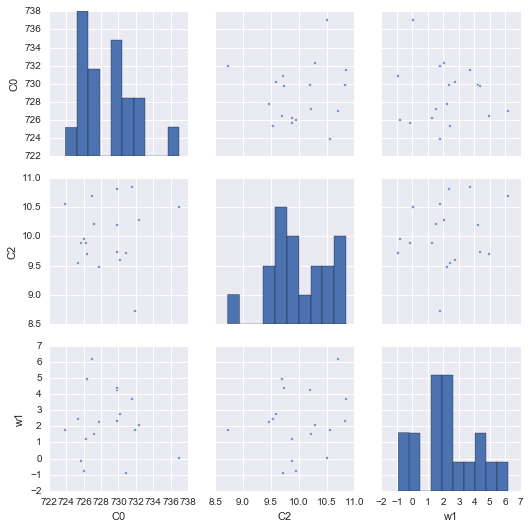

In [12]:
samples = test_sampler.chain
# reshape the samples into a 1D array where the colums are m and b
traces = samples.reshape(-1, 9).T
# create a pandas DataFrame with labels.  This will come in handy 
# in a moment, when we start using seaborn to plot our results 
# (among other things, it saves us the trouble of typing in labels
# for our plots)
parameter_samples = pd.DataFrame({'C0': traces[2], 'C2': traces[3], 'w1': traces[4]})
sns.pairplot(parameter_samples, markers='.')